# Bi-modal BNN Regression
This notebook mirrors `bi-modal.py` and adds inline visualization so that every 500 training epochs the generated figure is both saved and displayed.

In [ ]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import bayesnn as bnn


## Toy-Example Environment
This setup follows Fig. 5 from [Hernández-Lobato & Adams (2016)](https://arxiv.org/pdf/1605.07127).
- Draw inputs uniformly from the configured domain to create a wide coverage of x values.
- Flip a biased coin (controlled by `success_prob`) to decide whether a point comes from the cosine or sine mode with magnitudes `magnitude_1` and `magnitude_2`.
- Add Gaussian noise with standard deviation `noise` so the conditional target distribution remains bi-modal and noisy.
- Larger sample counts furnish richer posterior estimates but also increase training cost.

In [10]:
class Environment:
    def __init__(self, env_param):
        self.alpha = env_param["success_prob"]
        self.A1 = env_param["magnitude_1"]
        self.A2 = env_param["magnitude_2"]
        self.sigma = env_param["noise"]
        self.N = env_param["samples"]
        assert self.N > 0, "N must be positive"
        self.domain = env_param["domain"]
        self.x = np.random.uniform(
            low=self.domain[0], high=self.domain[1], size=[self.N, 1]
        )

        self.y = self.generate_func(
            x=self.x, alpha=self.alpha, A1=self.A1, A2=self.A2, sigma=self.sigma
        )

    def generate_func(self, x, alpha, A1, A2, sigma):
        y = np.zeros(x.shape)
        for i, xi in enumerate(x):
            if alpha <= np.random.uniform():
                y[i] = A1 * np.cos(xi) + np.random.normal(scale=sigma)
            else:
                y[i] = A2 * np.sin(xi) + np.random.normal(scale=sigma)
        return y

## Bayesian Neural Network Structure
- **Layers:** Input → BayesianLinear(1→50) → ReLU → BayesianLinear(50→50) → ReLU → BayesianLinear(50→50) → BayesianLinear(50→1).
- **BayesianLinear:** Each linear layer learns a distribution (mean & rho) over weights/biases, enabling stochastic forward passes.
- **Sampling:** Setting `sample=True` draws weights from their learned distributions and injects Gaussian observation noise (`out_noise_var`) into outputs.
- **Uncertainty:** Repeating stochastic passes yields predictive distributions that capture both model (weight) and observation uncertainty.
- **Training:** Alpha-divergence loss balances negative log-likelihood with KL regularization, keeping the posterior close to the prior (regularize) while fitting data.

In [11]:
class BNNRegressor(torch.nn.Module):
    def __init__(self, in_features, out_features, out_noise_var=1.0):
        super().__init__()
        self.numberNeurons = 50
        rho = 0.0
        self.input_layer = bnn.BayesianLinear(in_features, self.numberNeurons, rho=rho)
        self.relu = torch.nn.ReLU()
        self.hidden1 = bnn.BayesianLinear(self.numberNeurons, self.numberNeurons, rho=rho)
        self.hidden2 = bnn.BayesianLinear(self.numberNeurons, self.numberNeurons, rho=rho)
        self.output_layer = bnn.BayesianLinear(self.numberNeurons, out_features, rho=rho)
        self.out_noise_var = out_noise_var

    def forward(self, x, sample=False):
        x = self.relu(self.input_layer(x))
        x = self.relu(self.hidden1(x))
        x = self.output_layer(x)
        if not sample:
            return x
        return x + (torch.randn_like(x) * math.sqrt(self.out_noise_var))

[BNN bi-modal] iter=0000/1000 | loss=14299.8268 | neg_loglike=14297.2829 | kl=2.5438


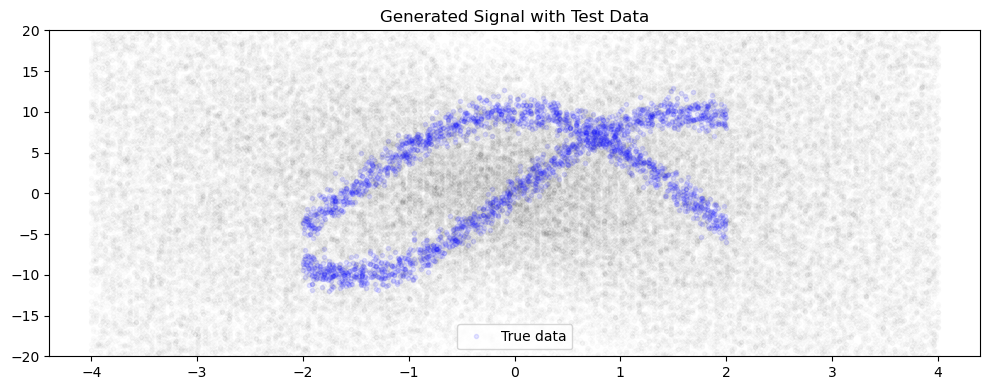

[BNN bi-modal] iter=0010/1000 | loss=14117.1146 | neg_loglike=14071.6134 | kl=45.5012
[BNN bi-modal] iter=0020/1000 | loss=13505.5990 | neg_loglike=13422.4254 | kl=83.1737
[BNN bi-modal] iter=0030/1000 | loss=14029.3791 | neg_loglike=13916.9074 | kl=112.4717
[BNN bi-modal] iter=0040/1000 | loss=13839.0311 | neg_loglike=13697.6505 | kl=141.3804
[BNN bi-modal] iter=0050/1000 | loss=13768.5931 | neg_loglike=13606.3554 | kl=162.2377
[BNN bi-modal] iter=0060/1000 | loss=13167.2266 | neg_loglike=12985.2744 | kl=181.9521
[BNN bi-modal] iter=0070/1000 | loss=12695.1800 | neg_loglike=12496.9502 | kl=198.2300
[BNN bi-modal] iter=0080/1000 | loss=12460.0244 | neg_loglike=12238.4618 | kl=221.5626
[BNN bi-modal] iter=0090/1000 | loss=12594.4246 | neg_loglike=12360.8199 | kl=233.6046
[BNN bi-modal] iter=0100/1000 | loss=12576.8587 | neg_loglike=12332.5268 | kl=244.3321
[BNN bi-modal] iter=0110/1000 | loss=12266.0783 | neg_loglike=12015.3043 | kl=250.7739
[BNN bi-modal] iter=0120/1000 | loss=12343.93

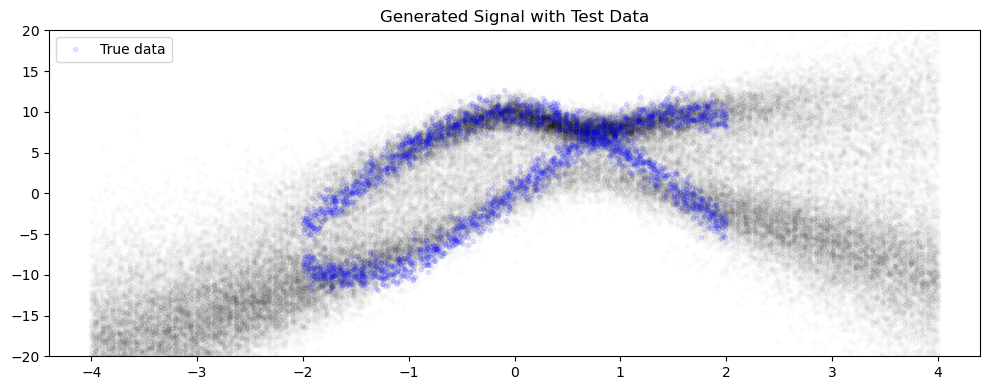

[BNN bi-modal] iter=0510/1000 | loss=9076.7253 | neg_loglike=8689.0200 | kl=387.7054
[BNN bi-modal] iter=0520/1000 | loss=8893.7941 | neg_loglike=8481.6233 | kl=412.1706
[BNN bi-modal] iter=0530/1000 | loss=8750.9402 | neg_loglike=8314.1830 | kl=436.7572
[BNN bi-modal] iter=0540/1000 | loss=8359.9926 | neg_loglike=7906.3334 | kl=453.6593
[BNN bi-modal] iter=0550/1000 | loss=8126.7881 | neg_loglike=7657.2055 | kl=469.5828
[BNN bi-modal] iter=0560/1000 | loss=7975.9170 | neg_loglike=7494.8978 | kl=481.0192
[BNN bi-modal] iter=0570/1000 | loss=7907.1358 | neg_loglike=7417.8484 | kl=489.2875
[BNN bi-modal] iter=0580/1000 | loss=7818.5028 | neg_loglike=7322.1383 | kl=496.3645
[BNN bi-modal] iter=0590/1000 | loss=7835.2750 | neg_loglike=7334.0854 | kl=501.1896
[BNN bi-modal] iter=0600/1000 | loss=7729.2405 | neg_loglike=7226.2477 | kl=502.9929
[BNN bi-modal] iter=0610/1000 | loss=7614.6158 | neg_loglike=7111.6343 | kl=502.9814
[BNN bi-modal] iter=0620/1000 | loss=7624.9845 | neg_loglike=7122

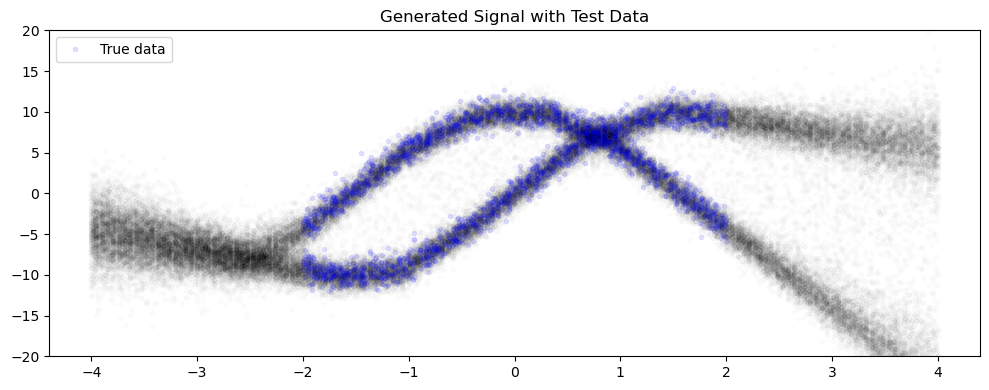


Training complete.


In [ ]:
# create instance of the env. 
env_params = {
    "success_prob": 0.5,
    "magnitude_1": 10,
    "magnitude_2": 10,
    "noise": 1.0,
    "domain": (-2, 2),
    "samples": 2500,
}

example_env = Environment(env_params)
model = BNNRegressor(1, 1, out_noise_var=1.0)
# Experiment with loss type, try also VBLoss
loss_fn = bnn.BNN_AlphaDivergenceLoss(
    model, mc=25, N=example_env.N, beta=1.0, return_components=True
 )
optimizer = optim.Adam(model.parameters(), lr=1e-2)

x_data = torch.Tensor(example_env.x)
target = torch.Tensor(example_env.y)

dataset = TensorDataset(x_data, target)
batch_size = 250
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

total_iters = 1000
for it in range(total_iters + 1):
    total_loss = 0.0
    total_loglike = 0.0
    total_kl = 0.0
    for xb, yb in loader:
        optimizer.zero_grad()
        loss, neg_loglike, kl = loss_fn(xb, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_loglike += neg_loglike.item()
        total_kl += kl.item()

    if it % 10 == 0 or it == total_iters:
        denom = max(len(loader), 1)
        avg_loss = total_loss / denom
        avg_loglike = total_loglike / denom
        avg_kl = total_kl / denom
        print(
            f"[BNN bi-modal] iter={it:04d}/{total_iters} | "
            f"loss={avg_loss:.4f} | neg_loglike={avg_loglike:.4f} | kl={avg_kl:.4f}"
        )

    if it % 500 == 0:
        domain_low, domain_high = env_params["domain"]
        x = np.linspace(domain_low - 2, domain_high + 2, 500).reshape(-1, 1)
        x = torch.tensor(x, dtype=x_data.dtype)

        preds = []
        for _ in range(150):
            per_point_preds = []
            for xi in x:
                xi = xi.unsqueeze(0)
                per_point_preds.append(model(xi, sample=True).detach().cpu())
            preds.append(torch.cat(per_point_preds, dim=0))
        y_samples = torch.stack(preds).cpu().numpy()[:, :, 0]

        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(
            example_env.x,
            example_env.y,
            "o",
            color="blue",
            ms=3,
            alpha=0.1,
            label="True data",
        )
        x_plot = x.cpu().numpy().ravel()
        for i in range(y_samples.shape[0]):
            ax.scatter(x_plot, y_samples[i], color="k", marker=".", alpha=0.01)
        ax.set_title("Generated Signal with Test Data")
        ax.set_ylim([-20.0, 20.0])
        ax.legend()
        fig.tight_layout()
        plt.show()
        plt.close(fig)

print("\nTraining complete.")